In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from plotnine import *

pd.set_option('display.width', 120)

# Données sur les lycées

## Valeur ajoutée des lycées

https://data.education.gouv.fr/explore/dataset/fr-en-indicateurs-de-resultat-des-lycees-gt_v2/information/

Dans les données, il y a de nombreuses informations :
-   informations techniques sur les lycées (nom de l'établissement, département, région, secteur...)
-   effectifs des présents à l'examen du bac, selon les différentes filières
-   taux de réussite et de mention, selon les différentes filières
-   nombre de mentions détaillé, à l'échelle agrégée
-   indicateurs de valeur ajoutée pour le taux de réussite et pour le taux de mention

In [2]:
va_data = pd.read_parquet("data/lycees_resultats.parquet")

va_data = va_data.assign(
    annee = va_data['annee'].astype(str).str[0:4].astype(int)
)

va_data = va_data.sort_values(["uai", "annee"]).reset_index()

va_data.columns

Index(['index', 'num_ligne', 'annee', 'uai', 'libelle_uai', 'code_region', 'libelle_region', 'libelle_academie',
       'code_departement', 'libelle_departement', 'code_commune', 'libelle_commune', 'secteur', 'presents_total',
       'taux_reu_total', 'va_reu_total', 'taux_acces_2nde', 'va_acces_2nde', 'taux_men_total', 'va_men_total',
       'presents_l', 'presents_es', 'presents_s', 'presents_gnle', 'presents_sti2d', 'presents_std2a', 'presents_stmg',
       'presents_stl', 'presents_st2s', 'presents_s2tmd', 'presents_sthr', 'taux_reu_l', 'taux_reu_es', 'taux_reu_s',
       'taux_reu_gnle', 'taux_reu_sti2d', 'taux_reu_std2a', 'taux_reu_stmg', 'taux_reu_stl', 'taux_reu_st2s',
       'taux_reu_s2tmd', 'taux_reu_sthr', 'va_reu_l', 'va_reu_es', 'va_reu_s', 'va_reu_gnle', 'va_reu_sti2d',
       'va_reu_std2a', 'va_reu_stmg', 'va_reu_stl', 'va_reu_st2s', 'va_reu_s2tmd', 'va_reu_sthr', 'eff_2nde',
       'eff_1ere', 'eff_term', 'taux_acces_1ere', 'taux_acces_term', 'va_acces_1ere', 'va_acce

In [3]:
va_data_0 = va_data[[
    'uai', 'annee', 'libelle_uai', 'code_region',
    'libelle_region', 'libelle_academie', 'code_departement',
    'libelle_departement', 'code_commune', 'libelle_commune', 'secteur'
    ]]

va_data_effectifs = va_data[[
    'uai', 'annee', 
    'eff_2nde', 'eff_1ere', 'eff_term', 
    'presents_total',
    'presents_l', 'presents_es', 'presents_s', 'presents_gnle', 'presents_sti2d', 'presents_std2a', 'presents_stmg', 'presents_stl', 'presents_st2s', 'presents_s2tmd', 'presents_sthr', 
    'nb_mentions_tb_avecf_g', 'nb_mentions_tb_sansf_g', 'nb_mentions_b_g', 'nb_mentions_ab_g', 
    'nb_mentions_tb_avecf_t', 'nb_mentions_tb_sansf_t', 'nb_mentions_b_t', 'nb_mentions_ab_t'
    ]]

va_data_acces = va_data[[
    'uai', 'annee', 
    'taux_acces_2nde', 'va_acces_2nde',
    'taux_acces_1ere', 'va_acces_1ere',
    'taux_acces_term', 'va_acces_term'
    ]]

va_data_reu = va_data[[
    'uai', 'annee', 
    'taux_reu_total', 'va_reu_total', 
    'taux_reu_l', 'taux_reu_es', 'taux_reu_s', 'taux_reu_gnle', 
    # 'taux_reu_sti2d', 'taux_reu_std2a', 'taux_reu_stmg', 'taux_reu_stl', 'taux_reu_st2s', 'taux_reu_s2tmd', 'taux_reu_sthr', 
    'va_reu_l', 'va_reu_es', 'va_reu_s', 'va_reu_gnle', 
    # 'va_reu_sti2d', 'va_reu_std2a', 'va_reu_stmg', 'va_reu_stl', 'va_reu_st2s', 'va_reu_s2tmd', 'va_reu_sthr'
    ]]

va_data_men = va_data[[
    'uai', 'annee', 
    'taux_men_l', 'taux_men_es', 'taux_men_s', 'taux_men_gnle', 'taux_men_sti2d', 'taux_men_std2a', 'taux_men_stmg', 'taux_men_stl', 'taux_men_st2s', 'taux_men_s2tmd', 'taux_men_sthr', 
    'va_men_l', 'va_men_es', 'va_men_s', 'va_men_gnle', 'va_men_sti2d', 'va_men_std2a', 'va_men_stmg', 'va_men_stl', 'va_men_st2s', 'va_men_s2tmd', 'va_men_sthr'
    ]]


In [4]:
va_data_reu.head(10)

,uai,annee,taux_reu_total,va_reu_total,taux_reu_l,taux_reu_es,taux_reu_s,taux_reu_gnle,va_reu_l,va_reu_es,va_reu_s,va_reu_gnle
0,0010006B,2012,89.0,-3.0,67,92,91,None,-23,1,-3,None
1,0010006B,2013,92.0,3.0,85,100,92,None,-2,6,3,None
2,0010006B,2014,93.0,3.0,89,100,90,None,-1,9,2,None
3,0010006B,2015,92.0,0.0,95,92,87,None,1,1,-5,None
4,0010006B,2016,91.0,-3.0,95,95,91,None,1,1,-1,None
5,0010006B,2017,94.0,2.0,88,86,95,None,-3,-3,3,None
6,0010006B,2018,88.0,-5.0,85,94,88,None,-7,1,-5,None
7,0010006B,2019,86.0,-7.0,94,91,85,None,-1,-5,-9,None
8,0010006B,2020,94.0,-4.0,86,94,95,None,-12,-5,-4,None
9,0010006B,2021,95.0,-1.0,None,None,None,97,None,None,None,-1


## Indices de position sociale

https://data.education.gouv.fr/explore/dataset/fr-en-ips_lycees/information/

L'indice de position sociale renseigne sur la composition sociale au sein des lycées.
En lien direct avec la théorie sociologie bourdieusienne, l'IPS propose donc de partir
de la PCS des parents d'élèves et d'en inférer une position sociale moyenne pour
l'ensemble de l'établissement. 

Plus l'IPS est grand, plus la position sociale des élèves de l'établissement est 
élévée, et plus les élèves sont supposés (sociologiquement) mieux réussir.

In [5]:
ips_data = pd.read_parquet("data/lycees_ips.parquet")

ips_data = ips_data.assign(
    annee = ips_data['rentree_scolaire'].str[5:9].astype(int)
)

ips_data = ips_data.sort_values(["uai", "annee"]).reset_index()

ips_data.columns

Index(['index', 'rentree_scolaire', 'academie', 'code_du_departement', 'departement', 'uai', 'nom_de_l_etablissment',
       'code_insee_de_la_commune', 'nom_de_la_commune', 'secteur', 'type_de_lycee', 'ips_voie_gt', 'ips_voie_pro',
       'ips_ensemble_gt_pro', 'ecart_type_de_l_ips_voie_gt', 'ecart_type_de_l_ips_voie_pro', 'annee'],
      dtype='object')

In [6]:
ips_data_0 = ips_data[[
    'uai', 'annee', 
    'nom_de_l_etablissment', 'secteur', 'type_de_lycee', 'academie', 
    'code_du_departement', 'departement', 
    'code_insee_de_la_commune', 'nom_de_la_commune'    
    ]]

ips_data_1 = ips_data[[
    'uai', 'annee', 
    'ips_voie_gt', 'ips_voie_pro', 'ips_ensemble_gt_pro', 
    'ecart_type_de_l_ips_voie_gt', 'ecart_type_de_l_ips_voie_pro'
    ]]

In [7]:
ips_data_1.head(10)

,uai,annee,ips_voie_gt,ips_voie_pro,ips_ensemble_gt_pro,ecart_type_de_l_ips_voie_gt,ecart_type_de_l_ips_voie_pro
0,0010001W,2017,NaN,89.2,89.2,NaN,NaN
1,0010001W,2018,NaN,89.7,89.7,NaN,NaN
2,0010001W,2019,NaN,89.1,89.1,NaN,NaN
3,0010001W,2020,NaN,90.5,90.5,NaN,29.3
4,0010001W,2021,NaN,88.6,88.6,NaN,29.4
5,0010001W,2022,NaN,91.1,91.1,NaN,30.1
6,0010006B,2017,105.5,84.3,97.3,NaN,NaN
7,0010006B,2018,106.3,82.1,97.2,NaN,NaN
8,0010006B,2019,103.7,83.2,96.2,NaN,NaN
9,0010006B,2020,105.5,83.5,97.2,34.0,26.7


## Jointure de deux sources

In [8]:
# Jointure entre les deux
data = pd.merge(
    ips_data_1,
    va_data_reu,
    on = ['uai', 'annee'],
    how = 'inner'
)

In [18]:
data.head()

,uai,annee,ips_voie_gt,ips_voie_pro,ips_ensemble_gt_pro,ecart_type_de_l_ips_voie_gt,ecart_type_de_l_ips_voie_pro,taux_reu_total,va_reu_total,taux_reu_l,taux_reu_es,taux_reu_s,taux_reu_gnle,va_reu_l,va_reu_es,va_reu_s,va_reu_gnle
0,0010006B,2017,105.5,84.3,97.3,NaN,NaN,94.0,2.0,88,86,95,0,-3,-3,3,None
1,0010006B,2018,106.3,82.1,97.2,NaN,NaN,88.0,-5.0,85,94,88,0,-7,1,-5,None
2,0010006B,2019,103.7,83.2,96.2,NaN,NaN,86.0,-7.0,94,91,85,0,-1,-5,-9,None
3,0010006B,2020,105.5,83.5,97.2,34.0,26.7,94.0,-4.0,86,94,95,0,-12,-5,-4,None
4,0010006B,2021,103.2,82.6,95.1,34.4,27.1,95.0,-1.0,None,None,None,97,None,None,None,-1


In [9]:
data.groupby(['annee']).count().iloc[:, 0]

annee
2017    2299
2018    2307
2019    2306
2020    2315
2021    2311
2022    2311
Name: uai, dtype: int64

In [10]:
data.columns


Index(['uai', 'annee', 'ips_voie_gt', 'ips_voie_pro', 'ips_ensemble_gt_pro', 'ecart_type_de_l_ips_voie_gt',
       'ecart_type_de_l_ips_voie_pro', 'taux_reu_total', 'va_reu_total', 'taux_reu_l', 'taux_reu_es', 'taux_reu_s',
       'taux_reu_gnle', 'va_reu_l', 'va_reu_es', 'va_reu_s', 'va_reu_gnle'],
      dtype='object')

In [11]:
data['taux_reu_gnle'] = data['taux_reu_gnle'].fillna(0).astype(int)
data['taux_reu_gnle']

0         0
1         0
2         0
3         0
4        97
         ..
13844    60
13845     0
13846     0
13847    86
13848    85
Name: taux_reu_gnle, Length: 13849, dtype: int64

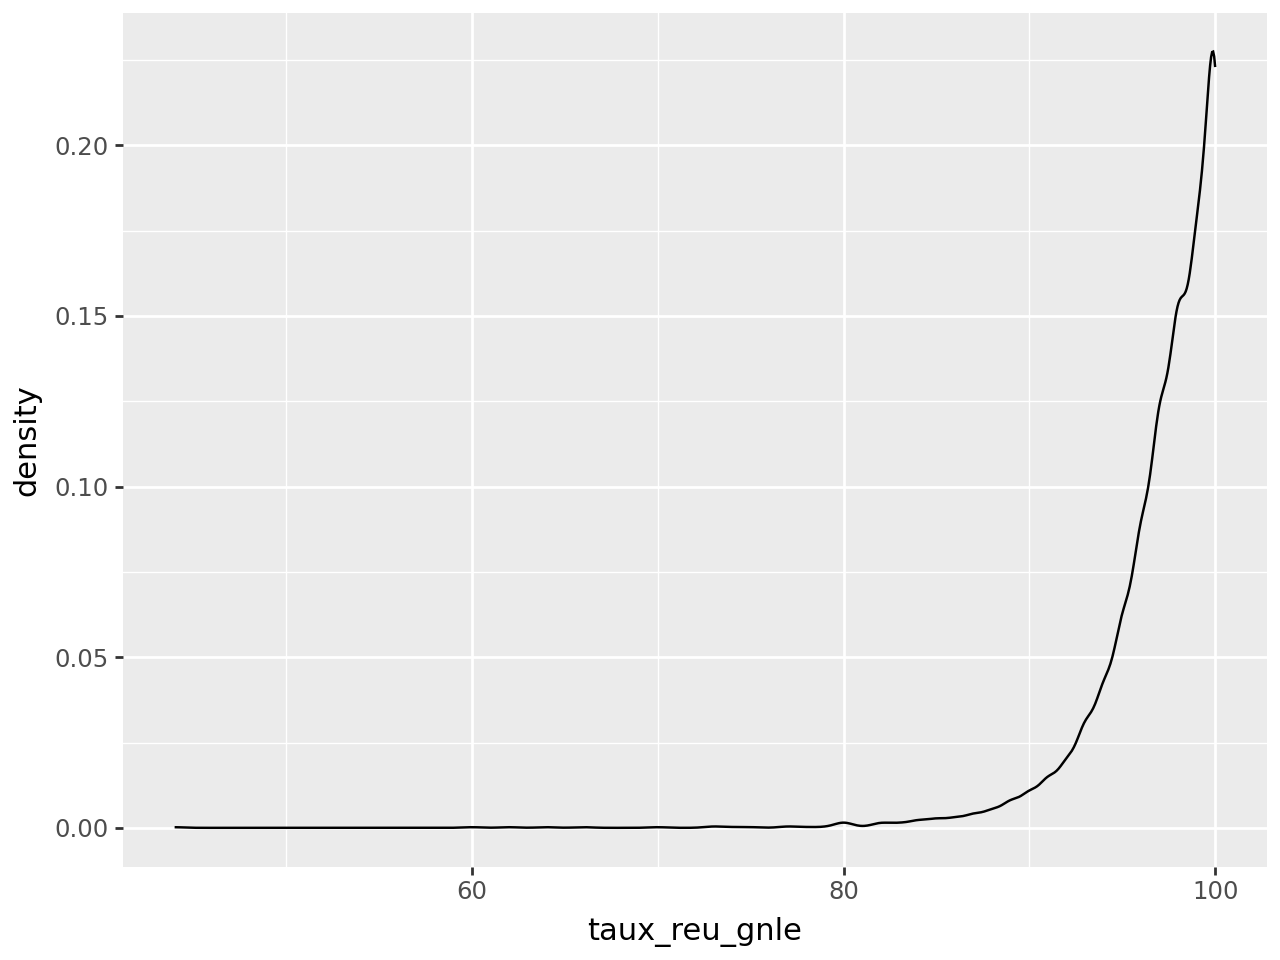

In [12]:
(
    ggplot(
        data[data["taux_reu_gnle"].astype(int) > 0],
        aes(x = "taux_reu_gnle")
        ) +
    geom_density()
)

In [13]:
data.dropna(subset=['taux_reu_gnle']).astype({'taux_reu_gnle': 'int'})

,uai,annee,ips_voie_gt,ips_voie_pro,ips_ensemble_gt_pro,ecart_type_de_l_ips_voie_gt,ecart_type_de_l_ips_voie_pro,taux_reu_total,va_reu_total,taux_reu_l,taux_reu_es,taux_reu_s,taux_reu_gnle,va_reu_l,va_reu_es,va_reu_s,va_reu_gnle
0,0010006B,2017,105.5,84.3,97.3,NaN,NaN,94.0,2.0,88,86,95,0,-3,-3,3,None
1,0010006B,2018,106.3,82.1,97.2,NaN,NaN,88.0,-5.0,85,94,88,0,-7,1,-5,None
2,0010006B,2019,103.7,83.2,96.2,NaN,NaN,86.0,-7.0,94,91,85,0,-1,-5,-9,None
3,0010006B,2020,105.5,83.5,97.2,34.0,26.7,94.0,-4.0,86,94,95,0,-12,-5,-4,None
4,0010006B,2021,103.2,82.6,95.1,34.4,27.1,95.0,-1.0,None,None,None,97,None,None,None,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13844,9760363R,2022,73.2,61.9,67.0,32.5,20.1,62.0,NaN,None,None,None,60,None,None,None,ND
13845,9760370Y,2019,67.8,62.8,66.8,NaN,NaN,59.0,NaN,62,46,66,0,ND,ND,ND,None
13846,9760370Y,2020,69.7,62.2,68.1,26.9,18.8,91.0,NaN,81,100,92,0,ND,ND,ND,None
13847,9760370Y,2021,67.7,60.8,66.0,26.9,18.3,85.0,NaN,None,None,None,86,None,None,None,ND


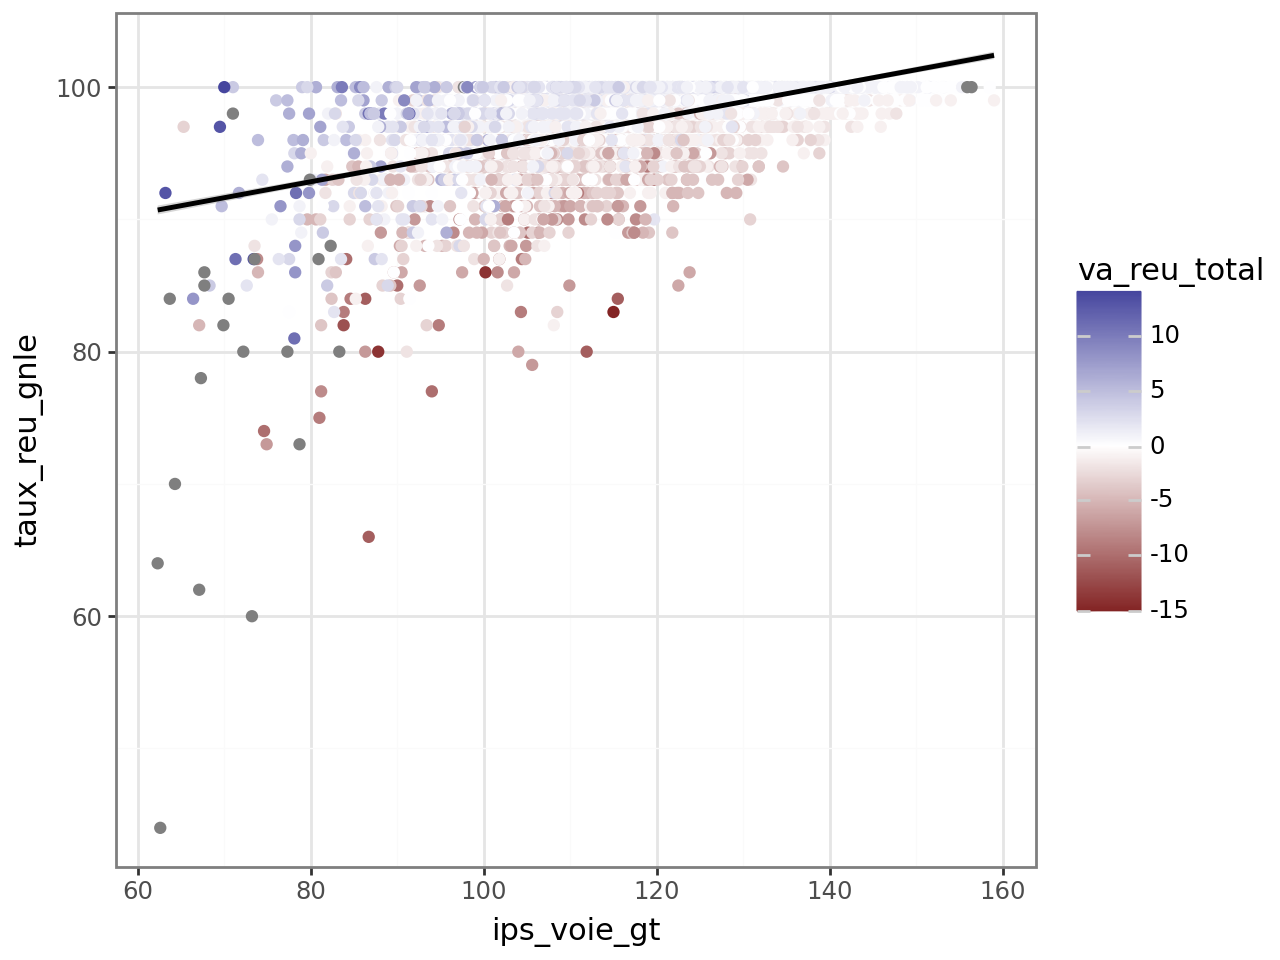

In [14]:
(
    ggplot(
        data[data["taux_reu_gnle"].astype(int) > 10],
        aes(
            x = "ips_voie_gt",
            y = "taux_reu_gnle",
            color = "va_reu_total"
    )
  ) + 
  geom_point() + 
  geom_smooth(method = 'lm') +
  scale_color_gradient2(
    # palette = "RdYlGn",
    # breaks = [-5, -2, 2, 5],
    # limits = [-100, 100],
    # direction = 1
  ) +
    theme_bw()

)

# Données sur les bibliothèques

https://www.insee.fr/fr/statistiques/8217525?sommaire=8217537



In [15]:
bpe_data = pd.read_parquet("data/bpe_equipements.parquet")

In [16]:
bpe_data.head()

,AN,NOMRS,CNOMRS,NUMVOIE,INDREP,TYPVOIE,LIBVOIE,CADR,CODPOS,DEPCOM,...,QVA,QUALI_QVA,ZUS,QUALI_ZUS,EPCI,UU2020,BV2022,AAV2020,DENS3,DENS7
0,2024,COMMISSARIAT DE POLICE DE POINTE À PITRE,,,,,QUARTIER LAFOND,,97139,97101,...,CSZ,_Z,0110110,1,200018653,9A701,97101,9A1,2,2
1,2024,DIR REG FINANCES PUBLIQUES GUADELOUPE,1ERE BDV POINTE-A-PITRE,,,RUE,DES FINANCES,CENTRE DES FINANCES PUBLIQUES,97139,97101,...,CSZ,_Z,HZ,1,200018653,9A701,97101,9A1,2,2
2,2024,DIR REG FINANCES PUBLIQUES GUADELOUPE,CFD DE ANTILLES-GUYANE,,,,BOISRIPEAUX,RESIDENCE LES MOUFFIAS,97139,97101,...,CSZ,_Z,HZ,3,200018653,9A701,97101,9A1,2,2
3,2024,APE ABYMES DOTHEMARE,,16,,ZAC,DE DOTHEMARE,ROND POINT DOTHEMARE,97139,97101,...,CSZ,_Z,0110110,3,200018653,9A701,97101,9A1,2,2
4,2024,APE ABYMES CARUEL,,,,AV,PATRICK SAINT ELOI,MORNE CARUEL,97139,97101,...,CSZ,_Z,HZ,2,200018653,9A701,97101,9A1,2,2
5,2024,MAISON DE JUSTICE ET DU DROIT DES ABYMES,,,,RUE,DES AMANDIERS RAIZET,,97139,97101,...,CSZ,_Z,0110120,1,200018653,9A701,97101,9A1,2,2
6,2024,FRANCE SERVICES LES ABYMES - LACROIX,,,,,LACROIX ABYMES,,97139,97101,...,CSZ,_Z,HZ,2,200018653,9A701,97101,9A1,2,2
7,2024,FRANCE SERVICES LES ABYMES - ESPACE RENÉ ELIE,,,,RUE,DE LA CHAPELLE DOUBS,ESPACE RENÉ ELIE,97139,97101,...,CSZ,_Z,HZ,1,200018653,9A701,97101,9A1,2,2
8,2024,FRANCE SERVICES LES ABYMES - MJC,,,,RTE,DU STADE RENE NABAJOTH,,97139,97101,...,CSZ,_Z,HZ,2,200018653,9A701,97101,9A1,2,2
9,2024,FRANCE SERVICES LES ABYMES - GRAND CAMP,,,,RES,WUTANG PARK GRAND CAMP,,97139,97101,...,CSZ,_Z,0110130,1,200018653,9A701,97101,9A1,2,2


In [39]:
biblio_data = bpe_data[bpe_data['TYPEQU'] == "F307"]
biblio_data = gpd.GeoDataFrame(
    biblio_data,
    geometry = gpd.points_from_xy(
        x = biblio_data['LAMBERT_X'], 
        y = biblio_data['LAMBERT_Y'], 
        crs = "EPSG:2154" 
    )
)


# Géolocalisation des lycées :

Pour fusionner les données biblio avec celles des lycées (calculer les distances entre lycées et biblios) , il fallait avoir des infos geo sur les localisations des lycées car le calcul de distances géodésiques nécessite des coordonnées précises. Or la base initiale des lycées ne contenait aucune information géographique (ni lat ni long )

Donc pour résoudre ce problème, on a identifié et importé une source complémentaire format geoJSON :

https://data.education.gouv.fr/explore/dataset/fr-en-adresse-et-geolocalisation-etablissements-premier-et-second-degre/export/?disjunctive.numero_uai&disjunctive.code_departement&disjunctive.code_region&disjunctive.code_academie&disjunctive.nature_uai&disjunctive.nature_uai_libe&disjunctive.code_commune&disjunctive.libelle_departement&disjunctive.libelle_region&disjunctive.libelle_academie&disjunctive.secteur_prive_code_type_contrat&disjunctive.secteur_prive_libelle_type_contrat&disjunctive.code_ministere&disjunctive.libelle_ministere

"Adresse et géolocalisation des établissements d'enseignement des premier et second degrés "

In [43]:
geoloc_gdf = gpd.read_file("data/etablissements.geojson")
geoloc_gdf.head()


,numero_uai,appellation_officielle,denomination_principale,patronyme_uai,secteur_public_prive_libe,adresse_uai,lieu_dit_uai,boite_postale_uai,code_postal_uai,localite_acheminement_uai,...,libelle_academie,position,secteur_prive_code_type_contrat,secteur_prive_libelle_type_contrat,code_ministere,libelle_ministere,date_ouverture,sigle,rnb,geometry
0,0212031U,ECOLE MATERNELLE,ECOLE MATERNELLE PUBLIQUE,None,Public,1 rue des Ecoles,None,None,21500,SENAILLY,...,Dijon,None,99.0,SANS OBJET,06,MINISTERE DE L'EDUCATION NATIONALE,1994-09-01,E.M.PU,['V78BN95P6TQY'],POINT (4.26658 47.5845)
1,0212032V,ECOLE ELEMENTAIRE JEAN FERRAT,ECOLE ELEMENTAIRE PUBLIQUE,JEAN FERRAT,Public,15 rue du 11 Novembre 1918,None,None,21260,SELONGEY,...,Dijon,None,99.0,SANS OBJET,06,MINISTERE DE L'EDUCATION NATIONALE,1994-09-01,E.E.PU,['2DCCFBCVDJ4D'],POINT (5.17712 47.58122)
2,0212034X,ECOLE ELEMENTAIRE PUBLIQUE,ECOLE ELEMENTAIRE PUBLIQUE,None,Public,Rue de l'Hôtel de Ville,None,None,21390,PRECY SOUS THIL,...,Dijon,None,99.0,SANS OBJET,06,MINISTERE DE L'EDUCATION NATIONALE,1994-09-01,E.E.PU,[],POINT (4.30836 47.3877)
3,0212055V,ECOLE ELEMENTAIRE PUBLIQUE BLANCHES FLEURS,ECOLE ELEMENTAIRE PUBLIQUE,BLANCHES FLEURS,Public,Impasse des Chilenes,None,None,21200,BEAUNE,...,Dijon,None,99.0,SANS OBJET,06,MINISTERE DE L'EDUCATION NATIONALE,1995-09-01,E.E.PU,[],POINT (4.83971 47.03599)
4,0212076T,ECOLE MATERNELLE,ECOLE MATERNELLE PUBLIQUE,R.P.I.,Public,Rue derrière la Cure,None,None,21320,VANDENESSE EN AUXOIS,...,Dijon,None,99.0,SANS OBJET,06,MINISTERE DE L'EDUCATION NATIONALE,1997-09-01,E.M.PU,['GAS6MSNB1ZKK'],POINT (4.61637 47.2187)


### Filtrer uniquement les lycées :

In [ ]:
geoloc_lycees = geoloc_gdf[
    geoloc_gdf["appellation_officielle"].str.contains("Lycée", case=False, na=False)
]

print("Nombre de lycées géolocalisés :", len(geoloc_lycees))



Nombre de lycées géolocalisés : 4898


### Fusion entre les données lycées et géographiques :

In [ ]:
# Fusion sur le code uai
lycees_geo = data.merge(
    geoloc_lycees[["numero_uai", "geometry"]],
    left_on="uai",
    right_on="numero_uai",
    how="left"
)

# Transformation en GeoDataFrame
lycees_geo = gpd.GeoDataFrame(lycees_geo, geometry="geometry", crs="EPSG:4326")



In [46]:
lycees_geo

,uai,annee,ips_voie_gt,ips_voie_pro,ips_ensemble_gt_pro,ecart_type_de_l_ips_voie_gt,ecart_type_de_l_ips_voie_pro,taux_reu_total,va_reu_total,taux_reu_l,taux_reu_es,taux_reu_s,taux_reu_gnle,va_reu_l,va_reu_es,va_reu_s,va_reu_gnle,numero_uai,geometry
0,0010006B,2017,105.5,84.3,97.3,NaN,NaN,94.0,2.0,88,86,95,0,-3,-3,3,None,0010006B,POINT (5.81829 46.11248)
1,0010006B,2018,106.3,82.1,97.2,NaN,NaN,88.0,-5.0,85,94,88,0,-7,1,-5,None,0010006B,POINT (5.81829 46.11248)
2,0010006B,2019,103.7,83.2,96.2,NaN,NaN,86.0,-7.0,94,91,85,0,-1,-5,-9,None,0010006B,POINT (5.81829 46.11248)
3,0010006B,2020,105.5,83.5,97.2,34.0,26.7,94.0,-4.0,86,94,95,0,-12,-5,-4,None,0010006B,POINT (5.81829 46.11248)
4,0010006B,2021,103.2,82.6,95.1,34.4,27.1,95.0,-1.0,None,None,None,97,None,None,None,-1,0010006B,POINT (5.81829 46.11248)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13844,9760363R,2022,73.2,61.9,67.0,32.5,20.1,62.0,NaN,None,None,None,60,None,None,None,ND,9760363R,POINT (45.19496 -12.91412)
13845,9760370Y,2019,67.8,62.8,66.8,NaN,NaN,59.0,NaN,62,46,66,0,ND,ND,ND,None,9760370Y,POINT (45.22198 -12.76676)
13846,9760370Y,2020,69.7,62.2,68.1,26.9,18.8,91.0,NaN,81,100,92,0,ND,ND,ND,None,9760370Y,POINT (45.22198 -12.76676)
13847,9760370Y,2021,67.7,60.8,66.0,26.9,18.3,85.0,NaN,None,None,None,86,None,None,None,ND,9760370Y,POINT (45.22198 -12.76676)


In [ ]:
# Reprojection GeoDataFrames en Lambert-93 :

lycees_gdf = lycees_geo.to_crs("EPSG:2154")
biblios_gdf = biblio_data.to_crs("EPSG:2154")

### Merge spatial : associe chaque lycée à la bibliothèque la plus proche :

In [80]:
lycees_proches = gpd.sjoin_nearest(
    lycees_gdf,
    biblio_data,
    how="left",
    distance_col="dist_proche_biblio_m"
)


In [81]:
lycees_proches.describe()


,annee,ips_voie_gt,ips_voie_pro,ips_ensemble_gt_pro,ecart_type_de_l_ips_voie_gt,ecart_type_de_l_ips_voie_pro,taux_reu_total,va_reu_total,taux_reu_gnle,index_right,...,NB_PDC_ACCELEREE,NB_PDC_LENTE,NB_PDC_RAPIDE,NB_PDC_ULTRARAPIDE,NB_JOURS_OUVERT,LAMBERT_X,LAMBERT_Y,LONGITUDE,LATITUDE,dist_proche_biblio_m
count,14510.000000,14509.000000,5178.000000,14510.000000,7271.000000,2659.000000,14510.000000,14437.000000,14510.000000,1.421200e+04,...,0.0,0.0,0.0,0.0,0.0,1.421200e+04,1.421200e+04,14212.000000,14212.000000,1.421200e+04
mean,2019.503859,114.607657,88.262437,112.366988,33.632568,29.133923,94.352378,-0.239385,30.425982,1.335590e+06,...,NaN,NaN,NaN,NaN,NaN,6.600433e+05,6.605281e+06,1.487561,46.705049,2.750064e+05
std,1.706924,14.706318,11.066515,15.861397,3.412796,3.722415,5.737157,3.351392,45.102742,7.690398e+05,...,NaN,NaN,NaN,NaN,NaN,2.164056e+05,6.628107e+05,8.198497,4.534734,1.457779e+06
min,2017.000000,62.300000,47.300000,57.900000,3.600000,0.000000,32.000000,-26.000000,0.000000,3.882600e+04,...,NaN,NaN,NaN,NaN,NaN,1.032500e+05,1.609133e+06,-60.835821,14.545221,7.889143e+00
25%,2018.000000,105.800000,81.500000,102.200000,32.300000,27.100000,92.000000,-2.000000,0.000000,6.848070e+05,...,NaN,NaN,NaN,NaN,NaN,5.352683e+05,6.471997e+06,0.599931,45.317792,4.368883e+02
50%,2020.000000,113.800000,87.600000,111.500000,34.000000,29.200000,96.000000,0.000000,0.000000,1.292751e+06,...,NaN,NaN,NaN,NaN,NaN,6.575905e+05,6.764740e+06,2.394399,47.907436,7.250155e+02
75%,2021.000000,123.700000,94.300000,122.500000,35.600000,31.400000,99.000000,1.000000,95.000000,2.005909e+06,...,NaN,NaN,NaN,NaN,NaN,8.313284e+05,6.864060e+06,4.720652,48.865539,1.102989e+03
max,2022.000000,159.100000,135.700000,159.100000,43.800000,49.500000,100.000000,24.000000,100.000000,2.822479e+06,...,NaN,NaN,NaN,NaN,NaN,1.230719e+06,7.105706e+06,9.451690,51.045587,9.609690e+06


### Nombre de bibliothèques situées dans différents rayons autour du lycée

In [82]:
rayons = [500, 1000, 2000, 5000]

for r in rayons:
        
    # Créer un buffer autour de chaque lycée
    buffer_gdf = lycees_gdf[["uai", "geometry"]].copy()
    buffer_gdf["geometry"] = buffer_gdf.buffer(r)
    
    # Spatial join : bibliothèques dans le buffer
    join = gpd.sjoin(biblio_data, buffer_gdf, how="inner", predicate="within")
    
    # Compter le nombre de bibliothèques par lycée
    counts = join.groupby("uai").size().rename(f"nb_biblio_{r}")
    
    # Fusion avec le GeoDataFrame lycées
    lycees_proches = lycees_proches.merge(counts, left_on="uai", right_index=True, how="left")
    
    lycees_proches[f"nb_biblio_{r}"] = lycees_proches[f"nb_biblio_{r}"].fillna(0)


In [83]:
lycees_proches.head()

,uai,annee,ips_voie_gt,ips_voie_pro,ips_ensemble_gt_pro,ecart_type_de_l_ips_voie_gt,ecart_type_de_l_ips_voie_pro,taux_reu_total,va_reu_total,taux_reu_l,...,UU2020,BV2022,AAV2020,DENS3,DENS7,dist_proche_biblio_m,nb_biblio_500,nb_biblio_1000,nb_biblio_2000,nb_biblio_5000
0,0010006B,2017,105.5,84.3,97.3,NaN,NaN,94.0,2.0,88,...,00360,01033,GEN,2,2,617.942724,0.0,6.0,18.0,36.0
1,0010006B,2018,106.3,82.1,97.2,NaN,NaN,88.0,-5.0,85,...,00360,01033,GEN,2,2,617.942724,0.0,6.0,18.0,36.0
2,0010006B,2019,103.7,83.2,96.2,NaN,NaN,86.0,-7.0,94,...,00360,01033,GEN,2,2,617.942724,0.0,6.0,18.0,36.0
3,0010006B,2020,105.5,83.5,97.2,34.0,26.7,94.0,-4.0,86,...,00360,01033,GEN,2,2,617.942724,0.0,6.0,18.0,36.0
4,0010006B,2021,103.2,82.6,95.1,34.4,27.1,95.0,-1.0,None,...,00360,01033,GEN,2,2,617.942724,0.0,6.0,18.0,36.0


In [84]:
cols_utiles = [
    "uai", "annee",
    "ips_voie_gt", "ips_voie_pro", "ips_ensemble_gt_pro",
    "ecart_type_de_l_ips_voie_gt", "ecart_type_de_l_ips_voie_pro",
    "taux_reu_total", "va_reu_total", "taux_reu_l", "taux_reu_es",
    "taux_reu_s", "taux_reu_gnle",
    "LONGITUDE", "LATITUDE", "geometry",
    "dist_proche_biblio_m", 
    "nb_biblio_500", "nb_biblio_1000",
    "nb_biblio_2000", "nb_biblio_5000"
]

lycees_final = lycees_proches[cols_utiles].copy()


In [78]:
lycees_final.describe()

,annee,ips_voie_gt,ips_voie_pro,ips_ensemble_gt_pro,ecart_type_de_l_ips_voie_gt,ecart_type_de_l_ips_voie_pro,taux_reu_total,va_reu_total,taux_reu_gnle,LONGITUDE,LATITUDE,dist_proche_biblio_m,nb_biblio_500,nb_biblio_1000,nb_biblio_2000,nb_biblio_5000
count,14510.000000,14509.000000,5178.000000,14510.000000,7271.000000,2659.000000,14510.000000,14437.000000,14510.000000,14212.000000,14212.000000,1.421200e+04,14510.000000,14510.000000,14510.000000,14510.000000
mean,2019.503859,114.607657,88.262437,112.366988,33.632568,29.133923,94.352378,-0.239385,30.425982,1.487561,46.705049,2.750064e+05,2.186285,6.466230,17.328325,69.366850
std,1.706924,14.706318,11.066515,15.861397,3.412796,3.722415,5.737157,3.351392,45.102742,8.198497,4.534734,1.457779e+06,3.731618,6.514319,16.686794,80.497287
min,2017.000000,62.300000,47.300000,57.900000,3.600000,0.000000,32.000000,-26.000000,0.000000,-60.835821,14.545221,7.889143e+00,0.000000,0.000000,0.000000,0.000000
25%,2018.000000,105.800000,81.500000,102.200000,32.300000,27.100000,92.000000,-2.000000,0.000000,0.599931,45.317792,4.368883e+02,0.000000,0.000000,6.000000,18.000000
50%,2020.000000,113.800000,87.600000,111.500000,34.000000,29.200000,96.000000,0.000000,0.000000,2.394399,47.907436,7.250155e+02,0.000000,6.000000,12.000000,42.000000
75%,2021.000000,123.700000,94.300000,122.500000,35.600000,31.400000,99.000000,1.000000,95.000000,4.720652,48.865539,1.102989e+03,6.000000,6.000000,24.000000,84.000000
max,2022.000000,159.100000,135.700000,159.100000,43.800000,49.500000,100.000000,24.000000,100.000000,9.451690,51.045587,9.609690e+06,30.000000,42.000000,126.000000,432.000000


In [ ]:
mq = lycees_final.isna().sum()
mq[mq > 0]

ips_voie_gt                         1
ips_voie_pro                     9332
ecart_type_de_l_ips_voie_gt      7239
ecart_type_de_l_ips_voie_pro    11851
va_reu_total                       73
taux_reu_l                       6981
taux_reu_es                      6100
taux_reu_s                       5596
LONGITUDE                         298
LATITUDE                          298
geometry                          298
dist_proche_biblio_m              298
dtype: int64